In [2]:
import tequila as tq
import numpy

In [3]:
geometry = """
H 0.0 0.0 0.0
H 0.0 0.0 1.0
"""

# Get the molecule object from tequila
# Transform from interacting fermion basis (molecule itself?) to spin-1/2 basis (qubits)
mol = tq.Molecule(geometry=geometry, basis_set="sto-3g", transformation="ReorderedJordanWigner")

H = mol.make_hamiltonian()
v = numpy.linalg.eigvalsh(H.to_matrix())

# Get the hamiltonian (which is now in spin-1/2 basis) in the hardcore boson approximation
# Basically, the spin 1/2 (up,down) gets mapped to (filled, empty)
HCB1 = mol.make_hardcore_boson_hamiltonian()

In [4]:
# Ground State
U1HCB = mol.make_ansatz(name="HCB-SPA", edges=[(0,1),], label=1)

E1 = tq.ExpectationValue(H=HCB1, U=U1HCB)
result = tq.minimize(E1, silent=True)

# fix variables (no need to change them anymore)
U1HCB = U1HCB.map_variables(variables=result.variables)

gs_energy = result.energy
gs_energy

-1.1011503301326668

In [5]:
# Excited State
U2HCB = mol.make_ansatz(name="HCB-SPA", edges=[(0,1),], label=2)

# Pairing model Hamiltonian in atomic basis
HCB2 = mol.use_native_orbitals().make_hardcore_boson_hamiltonian()
E2 = tq.ExpectationValue(H=HCB2, U=U2HCB)

# ????? What bases are we rotating between ?????
# Rotation between the bases
UR = mol.UR(0,1, angle=-numpy.pi/2)

# ????? Why do we need to change back to fermions ?????
# change from pairing model (hardcore-bosons) back to fermions
UF = mol.hcb_to_me()

# Measuring the |000> state since that's equivalent to the fidelity of excited and ground states
P0 = tq.paulis.Projector(wfn="|0000>")

# Expectation value for circuit w/ excited and ground state unitaries
S = tq.ExpectationValue(H=P0, U=U1HCB + UF + UR + UF.dagger() + U2HCB.dagger())

In [6]:
UF

circuit: 
X(target=(2,), control=(0,))
X(target=(3,), control=(1,))

In [7]:
# excited state objective
objective = E2 - gs_energy*S
result2 = tq.minimize(objective, silent = True)
ex_energy = result2.energy

In [8]:
print("energies and errors")
print("gs energy: {:+2.5f} | {:2.5f}".format(gs_energy, gs_energy-v[0]))

# for a bond distance of 1.0, state number 8 (so energy v[8]) is the one we are after
# for others it might change, so I just find the closest eigenenergy approximated
errors = [abs(ex_energy - e) for e in v]
print("ex energy: {:+2.5f} | {:2.5f}".format(ex_energy, min(errors)))

# let's compute the overlap (should be zero after optimization)
overlap = tq.simulate(S, variables=result2.variables)
print("overlap  : {:2.5f}".format(overlap))

energies and errors
gs energy: -1.10115 | 0.00000
ex energy: -0.35229 | 0.00000
overlap  : 0.00000


In [9]:
# E and E2 are just energy calculations analog to H4 (same model, basically the same 2-qubit circuit)
# S is the overlap between the two states
# as the two states live in different models, this needs to be incorporated
# UF transforms to Fermions and UR rotates the orbitals

print("Info on the Overlap Objective")
print(S)

# get the circuit (only one expectation value in the objective)
U = S.get_expectationvalues()[0].U

# compile all gates, but stop at "exponential-pauli" level
# here we only have 2-Paulis as generators
# the circuit will have: CNOTS, Ry, and XY-gates with fixed angle (since I can guess the orbital basis here without optimizing)
# the circuit just has 1 variable, so explicit optimization might be feasible
U = tq.compile_circuit(U, exponential_pauli=False)


# circuit as pretty picture (needs qpic installed | will send it with email as well)
try:
    U.export_to(filename="h2_excited_state_overlap_circuit.pdf")
except Exception as E:
    print("no qpic and/or latex installed ... sorry")

Info on the Overlap Objective
Objective with 1 unique expectation values
total measurements = 1
variables          = [((0, 1), 'D', 2)]
types              = not compiled
tikz2preview h2_excited_state_overlap_circuit.tikz
pdflatex -interaction=batchmode h2_excited_state_overlap_circuit.tex
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode


In [10]:
result = tq.minimize(S, silent=True)
print(result.variables)

((0, 1), 'D', 2) : -1.5725839597474947



In [11]:
E = tq.ExpectationValue(H=H, U=U)
print(E)

Objective with 1 unique expectation values
total measurements = 15
variables          = [((0, 1), 'D', 2)]
types              = not compiled


In [12]:
E2 = tq.compile(E, backend="cirq")
for e in E2.get_expectationvalues():
    print("this is the circuit")
    print(e.U.circuit)
    print("this is the Hamiltonian")
    print(e.H)
    print("")
    print("")

this is the circuit
                     ┌──┐                                          ┌──┐
0: ───X──────────X────@─────X───H────────X─────────────X───H───X─────@────X───X────────────────────────────────────────────────
                 │    │     │            │             │       │     │    │
1: ───Y^(-1/9)───@────┼@────@───Y^0.25───@───Y^-0.25───@───────@────@┼────@───Y^(0.318309886183791*f((((0, 1), 'D', 2),))_0)───
                      ││                                            ││
2: ───────────────────X┼────X───H────────X─────────────X───H───X────┼X─────────────────────────────────────────────────────────
                       │    │            │             │       │    │
3: ────────────────────X────@───Y^0.25───@───Y^-0.25───@───────@────X──────────────────────────────────────────────────────────
                     └──┘                                          └──┘
this is the Hamiltonian
(-0.3276+0.1372Z(0)+0.1372Z(2)-0.1304Z(1)-0.1304Z(3)+0.1566Z(0)Z(2)+0.0492Y(0)Y(1)Y

In [13]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

Get circuit directly from tequila optimization

In [14]:
circuit_from_optimization = E2.get_expectationvalues()[0].U.circuit
hamiltonian_from_tequila = E2.get_expectationvalues()[0].H

In [15]:
simulator = cirq.Simulator()

In [16]:
zero_state_populations = []
parameterized_angles = []

for parameterized_angle in range(-300, 0, 5):

    new_ops = []

    for moment in circuit_from_optimization:
        for op in moment:

            if op.gate not in [cirq.CNOT, cirq.H, cirq.X]:
                if type(op.gate.exponent) != float:
                    new_ops.append(cirq.YPowGate(exponent=parameterized_angle * 0.01 * 0.31830988618379069, global_shift=-0.5).on(cirq.LineQubit(1)))
                else:
                    new_ops.append(op)

            else:
                new_ops.append(op)

    new_circuit_from_optimization = cirq.Circuit(new_ops)

    result = simulator.simulate(new_circuit_from_optimization)
    zero_state_populations.append((result.final_state_vector[0].real)**2)
    parameterized_angles.append(parameterized_angle * 0.01)

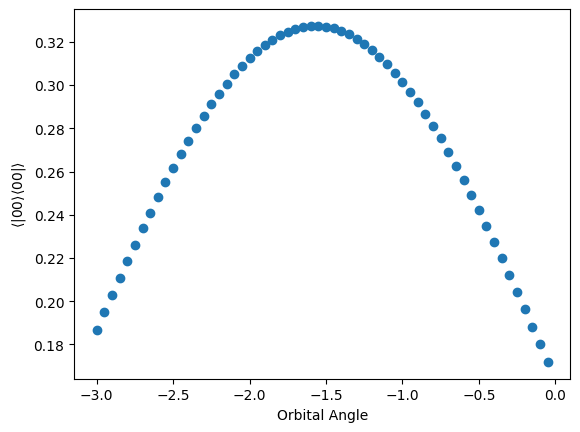

In [17]:
plt.scatter(parameterized_angles, zero_state_populations)
plt.xlabel("Orbital Angle")
plt.ylabel(r"$\langle |00 \rangle \langle 00| \rangle$")
plt.show()